In [14]:
import pandas as pd

# Path to unprocessed data file
initial_file = "V2_Perm_Clean.txt"

# Extract data into a dictionary
with open(initial_file, 'r') as input_file:
    # Master data list and permitivity value tracker
    data = []
    current_perm = None

    # Process all lines
    for line in input_file:
        curr_data = {}
        line = line.strip()

        # Skip blank lines
        if not line:
            continue

        # Header hit
        if line.startswith("#"):
            if "{Tested_Perm" in line:
                # Extract the tested perm from the line
                first_cut = line.split(";")[0]
                next_cut = first_cut.split("=")[2]
                current_perm = float(next_cut)
            else:
                # Skip extraneous headers
                continue

        # Data line found
        else:
            # Extract the frequency and s_param from the line
            frequency, s_param = line.split()
            frequency, s_param = float(frequency), float(s_param)

            # Add the data to the current data dictionary
            curr_data["Frequency"] = frequency
            curr_data["S_Param"] = s_param
            curr_data["Tested_Perm"] = current_perm

            # Add the current set of data to the list of data
            data.append(curr_data)

# Convert to a dataframe    
df = pd.DataFrame(data)
df


,Frequency,S_Param,Tested_Perm
0,0.00,-90.870470,40.0
1,0.01,-56.950480,40.0
2,0.02,-50.875755,40.0
3,0.03,-47.333106,40.0
4,0.04,-44.822122,40.0
...,...,...,...
21028,9.96,-7.507281,80.0
21029,9.97,-7.523806,80.0
21030,9.98,-7.539987,80.0
21031,9.99,-7.555828,80.0


In [15]:
# Create CSV file of processed data
df.to_csv("V2_Perm_Processed.csv", index=False)

In [16]:
from sklearn.model_selection import train_test_split

# Separate the data into features and target
X = df[["Frequency", "S_Param"]]
y = df["Tested_Perm"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=602, shuffle=True)

In [17]:
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor(base_score=0, objective="reg:squarederror", n_estimators=200, learning_rate=0.2, max_depth=7)
model.fit(X_train, y_train)

XGBRegressor(base_score=0, booster=None, callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [18]:
# Make predictions
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 5.3363


In [20]:
def accuracy_within_threshold(y_true, y_pred, threshold=0.15):
    relative_errors = np.abs(y_pred - y_true) / y_true
    accuracy = np.mean(relative_errors <= threshold) * 100

    return accuracy

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
    model_accuracy = accuracy_within_threshold(y_test, y_pred, threshold)
    print(f"Accuracy with {threshold * 100}% tolerance: {model_accuracy:.2f}%")


Accuracy with 5.0% tolerance: 78.49%
Accuracy with 10.0% tolerance: 87.28%
Accuracy with 15.0% tolerance: 91.56%
Accuracy with 20.0% tolerance: 93.94%
Accuracy with 25.0% tolerance: 95.86%
Accuracy with 30.0% tolerance: 97.12%
Accuracy with 35.0% tolerance: 97.98%
Accuracy with 40.0% tolerance: 98.65%
Accuracy with 45.0% tolerance: 98.91%
Accuracy with 50.0% tolerance: 99.22%


In [21]:
y_pred

array([72.984184, 76.14395 , 56.489853, ..., 45.48287 , 46.187202,
       70.830086], dtype=float32)

In [22]:
y_test

16906    72.0
19111    78.0
8895     56.0
14744    68.0
19589    78.0
         ... 
9946     58.0
1577     42.0
3915     46.0
3148     46.0
19271    78.0
Name: Tested_Perm, Length: 4207, dtype: float64

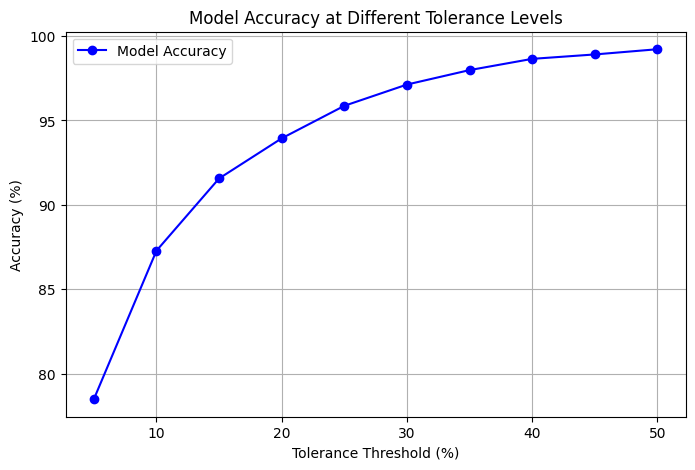

In [23]:
import matplotlib.pyplot as plt

# Define thresholds and calculate accuracy for each
accuracies = [accuracy_within_threshold(y_test, y_pred, t) for t in thresholds]

# Plot the accuracy vs. threshold
plt.figure(figsize=(8, 5))
plt.plot([t * 100 for t in thresholds], accuracies, marker='o', linestyle='-', color='b', label='Model Accuracy')

# Labels and title
plt.xlabel("Tolerance Threshold (%)")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy at Different Tolerance Levels")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [29]:
import m2cgen

model.fit(X_train, y_train)

with open("./xgb_model.dart", "w") as f:
    f.write(m2cgen.export_to_dart(model))

In [28]:
model.predict([[10, 0.5]])

array([61.086548], dtype=float32)